### Churn @ Robinhood
#### Load Libraries and Data

In [1]:
from numba import cuda

try:
    print("Available GPUs:", cuda.gpus)
except cuda.CudaSupportError as e:
    print("CUDA Error:", e)

Available GPUs: <Managed Device 0>


In [2]:
import cudf as cf
equity_df_raw = cf.read_csv('./data/equity_value_data.csv')
features_df_raw = cf.read_csv('./data/features_data.csv')

equity_df = equity_df_raw.copy()
features_df = features_df_raw.copy()

In [3]:
equity_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1119158 entries, 0 to 1119157
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype
---  ------        --------------    -----
 0   timestamp     1119158 non-null  object
 1   close_equity  1119158 non-null  float64
 2   user_id       1119158 non-null  object
dtypes: float64(1), object(2)
memory usage: 72.6+ MB


In [4]:
features_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   risk_tolerance                5584 non-null   object
 1   investment_experience         5584 non-null   object
 2   liquidity_needs               5584 non-null   object
 3   platform                      5584 non-null   object
 4   time_spent                    5584 non-null   float64
 5   instrument_type_first_traded  5584 non-null   object
 6   first_deposit_amount          5584 non-null   float64
 7   time_horizon                  5584 non-null   object
 8   user_id                       5584 non-null   object
dtypes: float64(2), object(7)
memory usage: 896.8+ KB


#### a). What percentage of users have churned in the data?
A user is *churned* when their equity falls below 10 usd for 28 consecutive calendar days or longer having perviously been at least 10 usd

**NOTE** Since no equities falls under 10 usd, threshold is set to a variable usd instead

In [5]:
# Set threshold
thresh = 20

# Step 1: Ensure the timestamp column is datetime and sort the data
equity_df['timestamp'] = cf.to_datetime(equity_df['timestamp'])
equity_df = equity_df.sort_values(['user_id', 'timestamp'])

# Step 2: Flag close_equity below threshold
equity_df[f'below_{thresh}'] = (equity_df['close_equity'] < thresh).astype(int)

# Step 3: Compute rolling 28-day windows for each user
equity_df[f'below_{thresh}_28d'] = equity_df.groupby('user_id')[f'below_{thresh}'].rolling(window=28, min_periods=28).sum().reset_index(0, drop=True)

# Step 4: Identify churn (continuous 28 days below $11)
equity_df['churn'] = (equity_df[f'below_{thresh}_28d'] == 28).astype(int).copy()

# Step 5: Check if the user ever had close_equity >= 11
# Group by 'user_id' to find the max close_equity
user_max_equity = equity_df.groupby('user_id')['close_equity'].max().reset_index()
user_max_equity.rename(columns={"close_equity": "max_equity"}, inplace=True)

# Merge back to associate max_equity with each user_id in the main DataFrame
equity_df = equity_df.merge(user_max_equity, on="user_id", how="left")

# Add a flag for users who had close_equity >= 11 at some point
equity_df[f'above_{thresh}_before'] = (equity_df['max_equity'] >= thresh).astype(int)

# Step 6: Filter churned users
churned_users = equity_df.loc[
    (equity_df['churn'] == 1) & (equity_df[f'above_{thresh}_before'] == 1),
    'user_id'
].unique()

# Step 7: Calculate the churn percentage
total_users = equity_df['user_id'].nunique()
churn_percentage = (len(churned_users) / total_users) * 100

print(f"Churned Percentage: {churn_percentage:.2f}%\n")
print(f"Churned Users: {churned_users}\n")
print(f"Total Users: {total_users}\n")

Churned Percentage: 4.76%

Churned Users: 0      01ef51aa8fab66b13d2249bc6ee68975
1      0109c34c307d14e477745b8e7f5aab94
2      03e9ef0a9024079ebdd6dad3af3ad981
3      0503b35d3715f13fec0a6b7319a32a4f
4      030f4ca7bb7bf14fe5a442b9bffc19e8
                     ...               
261    fcd8c26515e364f228c9e1f1510ea6ed
262    fcb9d49d5560f5a667d49902f0df4259
263    ff4e65d48ca13643ec8ce86c445dae8d
264    fc3e52dfa44438cd91838b1f48b7e57a
265    ffae713096867a32e74f633060667153
Name: user_id, Length: 266, dtype: object

Total Users: 5584



Find total days on platform for each user_id

In [6]:
equity_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1119158 entries, 0 to 1119157
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype
---  ------           --------------    -----
 0   timestamp        1119158 non-null  datetime64[ns]
 1   close_equity     1119158 non-null  float64
 2   user_id          1119158 non-null  object
 3   below_20         1119158 non-null  int64
 4   below_20_28d     971628 non-null   int64
 5   churn            971628 non-null   int64
 6   max_equity       1119158 non-null  float64
 7   above_20_before  1119158 non-null  int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 98.5+ MB


In [7]:
# Convert cudf DataFrame to pandas for grouping, if necessary
equity_df = equity_df.to_pandas()

# Group by `user_id` and calculate the total days on platform
total_days = equity_df.groupby('user_id')['timestamp'].agg(lambda x: (x.max() - x.min()).days + 1).reset_index()

# Rename the columns for clarity
total_days.columns = ['user_id', 'total_days_on_platform']

# Display the result
print(total_days)

                               user_id  total_days_on_platform
0     0012db34aa7b083f5714e7831195e54d                     365
1     001d6c77dbdb3213cead7673f250bfdc                     365
2     002e4653171ddc61c3cd30603cd7bd3e                     184
3     00384fa9be6fdca1b786bae70d78f88f                     177
4     0042aac295a0d4df88f4b83012778bd4                     365
...                                ...                     ...
5579  ff9ee08791e20724a86995ab2bc72578                     365
5580  ffa12d2f97e310910291f9b26fb2318d                     365
5581  ffae713096867a32e74f633060667153                     324
5582  ffbda9a14e07718e2b21fb03896d21c5                     185
5583  ffc1e622f3a0b2666f09a6dcb7f27918                     299

[5584 rows x 2 columns]


b). Build a classifier given a user with their features assigns a churn probability for every user and predicts which users will churn

In [8]:
# Create the 'churned' column
features_df['churned'] = features_df['user_id'].isin(churned_users).astype('int32')
features_df['churned'].value_counts()

churned
0    5318
1     266
Name: count, dtype: int64

In [9]:
features_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   risk_tolerance                5584 non-null   object
 1   investment_experience         5584 non-null   object
 2   liquidity_needs               5584 non-null   object
 3   platform                      5584 non-null   object
 4   time_spent                    5584 non-null   float64
 5   instrument_type_first_traded  5584 non-null   object
 6   first_deposit_amount          5584 non-null   float64
 7   time_horizon                  5584 non-null   object
 8   user_id                       5584 non-null   object
 9   churned                       5584 non-null   int32
dtypes: float64(2), int32(1), object(7)
memory usage: 918.7+ KB


In [10]:
features_df.describe().T

,count,mean,std,min,25%,50%,75%,max
time_spent,5584.0,34.509706,155.080551,0.0,2.848908,13.474708,33.823829,8788.32945
first_deposit_amount,5584.0,633.566805,2118.323263,0.0,50.000000,100.000000,500.000000,50000.00000
churned,5584.0,0.047636,0.213014,0.0,0.000000,0.000000,0.000000,1.00000


In [11]:
features_df['risk_tolerance'].value_counts()

risk_tolerance
high_risk_tolerance    3566
med_risk_tolerance     1779
low_risk_tolerance      239
Name: count, dtype: int64

In [12]:
features_df['investment_experience'].value_counts()

investment_experience
limited_investment_exp      2578
no_investment_exp           1796
good_investment_exp         1134
extensive_investment_exp      76
Name: count, dtype: int64

In [13]:
# change features of investment experience to 3
features_df['investment_experience'] = features_df['investment_experience'].replace({
    'extensive_investment_exp': 'good_investment_exp'
})
features_df['investment_experience'].value_counts()

investment_experience
limited_investment_exp    2578
no_investment_exp         1796
good_investment_exp       1210
Name: count, dtype: int64

In [14]:
features_df['liquidity_needs'].value_counts()

liquidity_needs
very_important_liq_need        4217
somewhat_important_liq_need    1109
not_important_liq_need          258
Name: count, dtype: int64

In [15]:
features_df['platform'].value_counts()

platform
iOS        3550
Android    1529
both        505
Name: count, dtype: int64

In [16]:
features_df['instrument_type_first_traded'].value_counts()

instrument_type_first_traded
stock       4827
etp          383
adr          197
mlp           55
reit          55
cef           20
wrt           16
0             13
rlt            9
lp             8
tracking       1
Name: count, dtype: int64

In [17]:
# Use vectorized operations to assign 'non_stock' to all values not equal to 'stock'
features_df['instrument_type_first_traded'] = (
    features_df['instrument_type_first_traded']
    .where(features_df['instrument_type_first_traded'] == 'stock', 'non_stock')
)

# Check the updated value counts
print(features_df['instrument_type_first_traded'].value_counts())

instrument_type_first_traded
stock        4827
non_stock     757
Name: count, dtype: int64


In [18]:
features_df['time_horizon'].value_counts()

time_horizon
short_time_horizon    2833
long_time_horizon     1833
med_time_horizon       918
Name: count, dtype: int64

In [19]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

features_df = features_df.to_pandas()

# Merge total_days into features_df on 'user_id'
features_df = features_df.merge(total_days, on='user_id', how='left')

# Handle missing values in total_days
features_df['total_days_on_platform'] = features_df['total_days_on_platform'].fillna(0)

# Rename column for clarity
features_df.rename(columns={'total_days_on_platform': 'total_days'}, inplace=True)

# Drop `user_id` and `churned` columns for training
features_df = features_df.drop(columns=['user_id'])

# Verify the merge worked correctly
print(features_df.columns)

# Identify categorical and numerical features
categorical_features = ['risk_tolerance', 'investment_experience', 'liquidity_needs', 'platform', 
                        'instrument_type_first_traded', 'time_horizon']
numerical_features = ['time_spent', 'first_deposit_amount', 'total_days']

# Define preprocessing for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=True, handle_unknown='ignore', min_frequency=0.01)

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define anomaly detection models and parameter grids
param_grids = {
    'IsolationForest': {
        'model__contamination': [0.005, 0.01, 0.02, 0.05],
        'model__max_samples': [128, 256, 'auto'],
        'model__max_features': [0.25, 0.5, 0.75, 1.0]
    },
    'LocalOutlierFactor': {
        'model__n_neighbors': [10, 20, 35, 50],
        'model__leaf_size': [10, 25, 30, 50],
        'model__contamination': [0.005, 0.01, 0.02, 0.05]
    },
    'OneClassSVM': {
        'model__nu': [0.005, 0.01, 0.05, 0.1],
        'model__gamma': ['scale', 'auto'],
        'model__kernel': ['rbf', 'poly', 'linear']
    }
}

true_labels = features_df['churned']  # Ground truth labels for evaluation

for name, param_grid in param_grids.items():
    if name == 'IsolationForest':
        model = IsolationForest(random_state=42)
    elif name == 'LocalOutlierFactor':
        model = LocalOutlierFactor(novelty=True)
    elif name == 'OneClassSVM':
        model = OneClassSVM()

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        scoring='f1_macro',  # Adjust scoring based on your metric of interest
        cv=5
    )

    grid_search.fit(features_df.drop(columns=['churned']), true_labels)
    best_pipeline = grid_search.best_estimator_

    # Predict using the best pipeline
    predictions = best_pipeline.predict(features_df.drop(columns=['churned']))
    binary_predictions = (predictions == 1).astype(int)

    # Print classification report
    print(f"\n{name} Best Parameters: {grid_search.best_params_}\n")
    print(f"{name} Classification Report:\n")
    print(classification_report(true_labels, binary_predictions))

    # Print feature importances if available
    if hasattr(best_pipeline.named_steps['model'], 'feature_importances_'):
        feature_importances = best_pipeline.named_steps['model'].feature_importances_
        feature_names = numerical_features + list(best_pipeline.named_steps['preprocessor']
                                                  .transformers_[1][1]
                                                  .get_feature_names_out(categorical_features))
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)
        print(f"\n{name} Feature Importances:\n")
        print(importance_df)


Index(['risk_tolerance', 'investment_experience', 'liquidity_needs',
       'platform', 'time_spent', 'instrument_type_first_traded',
       'first_deposit_amount', 'time_horizon', 'churned', 'total_days'],
      dtype='object')

IsolationForest Best Parameters: {'model__contamination': 0.05, 'model__max_features': 0.75, 'model__max_samples': 128}

IsolationForest Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.05      0.10      5318
           1       0.05      0.98      0.09       266

    accuracy                           0.10      5584
   macro avg       0.52      0.52      0.10      5584
weighted avg       0.94      0.10      0.10      5584


LocalOutlierFactor Best Parameters: {'model__contamination': 0.005, 'model__leaf_size': 10, 'model__n_neighbors': 10}

LocalOutlierFactor Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.00      0.01      5318
          

In [20]:
# Define the new set of features
categorical_features = ['risk_tolerance', 'investment_experience', 'liquidity_needs', 'time_horizon']
numerical_features = ['first_deposit_amount', 'time_spent', 'total_days']

# Update the preprocessing pipeline
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=True, handle_unknown='ignore', min_frequency=0.01)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Rerun the models with the updated feature set
for name, param_grid in param_grids.items():
    if name == 'IsolationForest':
        model = IsolationForest(random_state=42)
    elif name == 'LocalOutlierFactor':
        model = LocalOutlierFactor(novelty=True)
    elif name == 'OneClassSVM':
        model = OneClassSVM()

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        scoring='f1_macro',  # Adjust scoring based on your metric of interest
        cv=5
    )

    grid_search.fit(features_df[categorical_features + numerical_features], true_labels)
    best_pipeline = grid_search.best_estimator_

    # Predict using the best pipeline
    predictions = best_pipeline.predict(features_df[categorical_features + numerical_features])
    binary_predictions = (predictions == 1).astype(int)

    # Print classification report
    print(f"\n{name} Best Parameters: {grid_search.best_params_}\n")
    print(f"{name} Classification Report:\n")
    print(classification_report(true_labels, binary_predictions))

    # Print feature importances if available
    if hasattr(best_pipeline.named_steps['model'], 'feature_importances_'):
        feature_importances = best_pipeline.named_steps['model'].feature_importances_
        feature_names = numerical_features + list(best_pipeline.named_steps['preprocessor']
                                                  .transformers_[1][1]
                                                  .get_feature_names_out(categorical_features))
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)
        print(f"\n{name} Feature Importances:\n")
        print(importance_df)



IsolationForest Best Parameters: {'model__contamination': 0.005, 'model__max_features': 0.75, 'model__max_samples': 128}

IsolationForest Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.01      0.01      5318
           1       0.05      1.00      0.09       266

    accuracy                           0.05      5584
   macro avg       0.52      0.50      0.05      5584
weighted avg       0.95      0.05      0.01      5584


LocalOutlierFactor Best Parameters: {'model__contamination': 0.02, 'model__leaf_size': 25, 'model__n_neighbors': 10}

LocalOutlierFactor Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.02      0.03      5318
           1       0.05      1.00      0.09       266

    accuracy                           0.06      5584
   macro avg       0.52      0.51      0.06      5584
weighted avg       0.94      0.06      0.04      5584


OneClassSVM Best Par

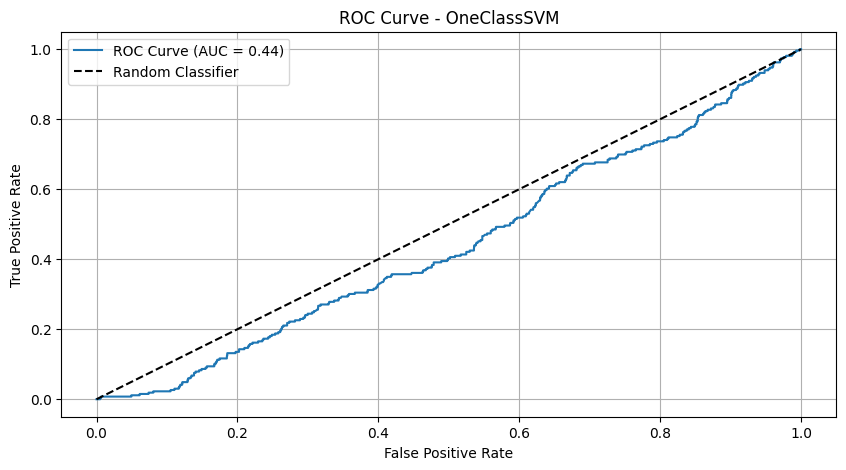

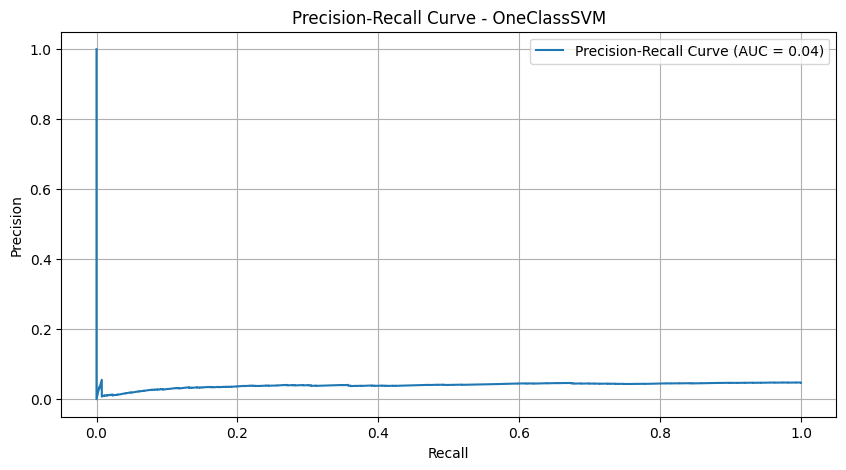

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Define the preprocessing pipeline
categorical_features = ['risk_tolerance', 'investment_experience', 'liquidity_needs', 'time_horizon']
numerical_features = ['first_deposit_amount', 'time_spent', 'total_days']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore', min_frequency=0.01)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Combine preprocessing with the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', OneClassSVM(gamma='auto', kernel='poly', nu=0.01))
])

# Fit the pipeline
pipeline.fit(features_df.drop(columns=['churned']))

# Get decision scores
decision_scores = pipeline.named_steps['model'].decision_function(
    pipeline.named_steps['preprocessor'].transform(features_df.drop(columns=['churned']))
)

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(true_labels, decision_scores)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(true_labels, decision_scores)
pr_auc = auc(recall, precision)

# Plot ROC Curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - OneClassSVM")
plt.legend()
plt.grid()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, label=f"Precision-Recall Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - OneClassSVM")
plt.legend()
plt.grid()
plt.show()


Autoencoders for Anomaly Detection
Autoencoders learn to reconstruct normal data and identify anomalies as samples with high reconstruction error.

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report

# Preprocess the data
categorical_features = ['risk_tolerance', 'investment_experience', 'liquidity_needs', 'platform', 'instrument_type_first_traded']
numerical_features = ['time_spent', 'first_deposit_amount', 'total_days']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

X = preprocessor.fit_transform(features_df.drop(columns=['churned']))

# Define the Autoencoder
input_dim = X.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(64, activation="relu")(input_layer)
encoder = Dense(32, activation="relu")(encoder)
decoder = Dense(64, activation="relu")(encoder)
output_layer = Dense(input_dim, activation="sigmoid")(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
autoencoder.fit(X, X, epochs=50, batch_size=64, shuffle=True, validation_split=0.1)

# Calculate reconstruction error
reconstruction = autoencoder.predict(X)
reconstruction_error = tf.reduce_mean(tf.square(X - reconstruction), axis=1).numpy()

# Evaluate using thresholds
threshold = reconstruction_error.mean() + 2 * reconstruction_error.std()
predictions = (reconstruction_error > threshold).astype(int)

# Print the classification report
print(classification_report(features_df['churned'], predictions))


2025-01-24 10:43:32.366966: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 10:43:32.468420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737744212.510320    6550 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737744212.522966    6550 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 10:43:32.633362: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Epoch 1/50


I0000 00:00:1737744215.718256    6950 service.cc:148] XLA service 0x7e6120017a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737744215.718369    6950 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2025-01-24 10:43:35.738339: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737744215.822879    6950 cuda_dnn.cc:529] Loaded cuDNN version 90300


54/79 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 0.4048

I0000 00:00:1737744217.170155    6950 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.3877 - val_loss: 0.1696
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2322 - val_loss: 0.0974
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2071 - val_loss: 0.0768
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1831 - val_loss: 0.0723
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1295 - val_loss: 0.0699
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2369 - val_loss: 0.0682
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1913 - val_loss: 0.0673
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1379 - val_loss: 0.0669
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1421 - val_loss: 0.0666
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1317 - val_loss: 0.0665
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1420 - val_loss: 0.0664
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1037 - val_loss: 0.0664

Gaussian Mixture Models (GMM)
GMM fits a mixture of Gaussians and identifies low-density regions as anomalies.

In [23]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X)

# Log-likelihood as anomaly score
log_likelihood = gmm.score_samples(X)
threshold = log_likelihood.mean() - 2 * log_likelihood.std()
predictions = (log_likelihood < threshold).astype(int)
print(classification_report(features_df['churned'], predictions))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      5318
           1       0.02      0.02      0.02       266

    accuracy                           0.91      5584
   macro avg       0.49      0.49      0.49      5584
weighted avg       0.91      0.91      0.91      5584



Hidden Markov Models (HMM)
HMMs model temporal data and identify low-probability sequences as anomalies.

In [24]:
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import classification_report
import numpy as np

# Fit an HMM model
hmm = GaussianHMM(n_components=2, covariance_type="diag", n_iter=100, random_state=42)
hmm.fit(X)

# Calculate log-likelihood for each sample
log_likelihoods = np.array([hmm.score(X[i:i+1]) for i in range(len(X))])

# Use log-likelihood as the anomaly score
threshold = log_likelihoods.mean() - 2 * log_likelihoods.std()
predictions = (log_likelihoods < threshold).astype(int)

# Evaluate the results
print(classification_report(features_df['churned'], predictions))


              precision    recall  f1-score   support

           0       0.95      1.00      0.98      5318
           1       0.00      0.00      0.00       266

    accuracy                           0.95      5584
   macro avg       0.48      0.50      0.49      5584
weighted avg       0.91      0.95      0.93      5584



/home/oem/Documents/github/magnimind_projects/magpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/oem/Documents/github/magnimind_projects/magpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/oem/Documents/github/magnimind_projects/magpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

k-Means Clustering
k-Means identifies anomalies based on their distance to cluster centroids.

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

# Distance to the closest cluster centroid as anomaly score
_, distances = pairwise_distances_argmin_min(X, kmeans.cluster_centers_)
threshold = distances.mean() + 2 * distances.std()
predictions = (distances > threshold).astype(int)
print(classification_report(features_df['churned'], predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5318
           1       0.03      0.01      0.01       266

    accuracy                           0.94      5584
   macro avg       0.49      0.50      0.49      5584
weighted avg       0.91      0.94      0.92      5584



Apply SMOTE to Balance the Dataset

In [26]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd
import numpy as np

# Example dataset
X = features_df.drop(columns=['churned'])
y = features_df['churned']

# Encode categorical features in X using OneHotEncoder
categorical_columns = X.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Updated argument

# Transform categorical features
X_encoded = encoder.fit_transform(X[categorical_columns])

# Combine numerical and encoded categorical features
X_numeric = X.drop(columns=categorical_columns)
X_transformed = np.hstack((X_numeric.values, X_encoded))

# Encode target variable y using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(pd.Series(y_train).value_counts())

print("\nAfter SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Train a classifier on the resampled dataset
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Evaluate the model on the test set
y_pred = clf.predict(X_test)

# Decode predictions back to original labels for interpretation
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

print("\nClassification Report:")
print(classification_report(y_test_decoded, y_pred_decoded))


Before SMOTE:
0    4254
1     213
Name: count, dtype: int64

After SMOTE:
0    4254
1    4254
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1064
           1       0.14      0.02      0.03        53

    accuracy                           0.95      1117
   macro avg       0.55      0.51      0.50      1117
weighted avg       0.91      0.95      0.93      1117



In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np

# Example dataset
# X = features_df.drop(columns=['churned'])
# y = features_df['churned']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify numeric and categorical columns
numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X_train.select_dtypes(include=['object']).columns

# Preprocessing pipeline for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('log_transform', FunctionTransformer(np.log1p, validate=True))  # Log transform
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

# Create a pipeline with preprocessing and model
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight="balanced"))
])

# Train the pipeline
clf_pipeline.fit(X_train, y_train)

# Feature importance with permutation importance
perm_importance = permutation_importance(
    clf_pipeline, X_train, y_train, scoring='f1', n_repeats=10, random_state=42
)

# Show feature importance
for i, col in enumerate(X_train.columns):
    print(f"{col}: {perm_importance.importances_mean[i]:.4f}")

# Predict on the test set
y_pred = clf_pipeline.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


risk_tolerance: 0.3263
investment_experience: 0.4314
liquidity_needs: 0.2004
platform: 0.2914
time_spent: 0.6256
instrument_type_first_traded: 0.1042
first_deposit_amount: 0.7386
time_horizon: 0.3800
total_days: 0.4695

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1064
           1       0.00      0.00      0.00        53

    accuracy                           0.94      1117
   macro avg       0.48      0.49      0.48      1117
weighted avg       0.91      0.94      0.92      1117

